In [22]:

!pip install -q lightgbm xgboost


In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


In [25]:
# Load data
train_path = "Titanic_train.csv"   # change path if needed
test_path = "Titanic_test.csv"     # optional

train_df = pd.read_csv(train_path)
print("Train shape:", train_df.shape)
display(train_df.head())

# Quick info and missing counts
print("\nInfo:")
display(train_df.info())
print("\nMissing values per column:")
print(train_df.isnull().sum())

print("\nTarget distribution (Survived):")
print(train_df['Survived'].value_counts(normalize=False))


Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Target distribution (Survived):
Survived
0    549
1    342
Name: count, dtype: int64


In [26]:
# Feature engineering
df = train_df.copy()

# Extract title from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
# Map rare titles to 'Rare'
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# Family features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Drop columns not used directly (keep PassengerId for possible submission)
drop_cols = ['Ticket', 'Cabin', 'Name']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

display(df.head(6))
print("\nColumns now:", df.columns.tolist())


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,1,1
5,6,0,3,male,NaN,0,0,8.4583,Q,Mr,1,1



Columns now: ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']


In [29]:
# Preprocessing setup
# Identify columns
target = 'Survived'
id_col = 'PassengerId' if 'PassengerId' in df.columns else None

# Numeric and categorical columns (after feature engineering)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop([target])
if id_col:
    numeric_cols = numeric_cols.drop(id_col)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", list(numeric_cols))
print("Categorical columns:", cat_cols)

# Numeric pipeline: median impute (scaling not required for tree models, but safe)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # optional for some models
])

# Categorical pipeline: most frequent impute + one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, list(numeric_cols)),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')  # drop other columns (like PassengerId)

Numeric columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical columns: ['Sex', 'Embarked', 'Title']


In [30]:
# Split data
X = df.drop(columns=[target])
y = df[target]

# We will hold out a validation set (20%) and use later CV for tuning
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Valid:", X_valid.shape)


Train: (712, 11) Valid: (179, 11)


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

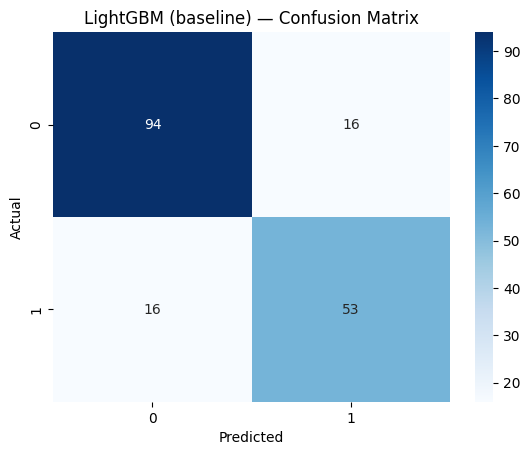


Classification report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


XGBoost (baseline) metrics:
Accuracy : 0.8044692737430168
Precision: 0.75
Recall   : 0.7391304347826086
F1       : 0.7445255474452555
ROC-AUC  : 0.8356389986824769


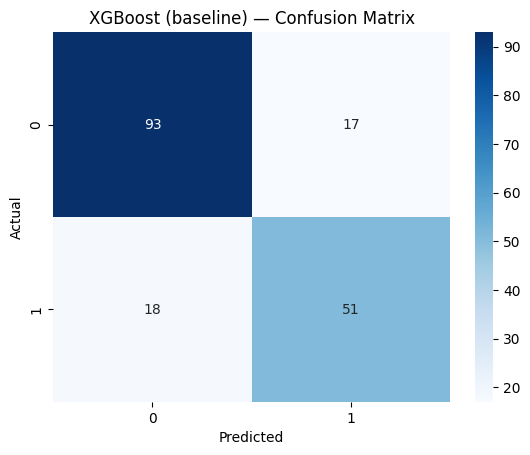


Classification report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [31]:
# Baseline LGBM and XGB pipelines

# LGBM pipeline
lgbm_pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LGBMClassifier(random_state=42))
])

# XGB pipeline (with common safe args)
xgb_pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Fit baseline LGBM
lgbm_pipe.fit(X_train, y_train)
lgbm_pred = lgbm_pipe.predict(X_valid)
lgbm_proba = lgbm_pipe.predict_proba(X_valid)[:,1] if hasattr(lgbm_pipe.named_steps['clf'], "predict_proba") else None

# Fit baseline XGB
xgb_pipe.fit(X_train, y_train)
xgb_pred = xgb_pipe.predict(X_valid)
xgb_proba = xgb_pipe.predict_proba(X_valid)[:,1] if hasattr(xgb_pipe.named_steps['clf'], "predict_proba") else None

# Evaluation helper
def print_metrics(name, y_true, y_pred, y_proba=None):
    print(f"\n{name} metrics:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1       :", f1_score(y_true, y_pred))
    if y_proba is not None:
        try:
            print("ROC-AUC  :", roc_auc_score(y_true, y_proba))
        except:
            pass
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    print("\nClassification report:\n", classification_report(y_true, y_pred))

print_metrics("LightGBM (baseline)", y_valid, lgbm_pred, lgbm_proba)
print_metrics("XGBoost (baseline)",  y_valid, xgb_pred,  xgb_proba)


In [32]:
# 5-fold CV accuracy (Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm_cv_scores = cross_val_score(lgbm_pipe, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
xgb_cv_scores  = cross_val_score(xgb_pipe, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print("LGBM CV accuracy: {:.4f} ± {:.4f}".format(lgbm_cv_scores.mean(), lgbm_cv_scores.std()))
print("XGB  CV accuracy: {:.4f} ± {:.4f}".format(xgb_cv_scores.mean(), xgb_cv_scores.std()))


LGBM CV accuracy: 0.8283 ± 0.0231
XGB  CV accuracy: 0.8204 ± 0.0258


In [33]:
# RandomizedSearchCV tuning (small)
lgbm_param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [-1, 3, 5, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [31, 63]
}

xgb_param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 4, 6],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm_search = RandomizedSearchCV(lgbm_pipe, lgbm_param_dist, n_iter=8, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
xgb_search  = RandomizedSearchCV(xgb_pipe,  xgb_param_dist,  n_iter=8, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)

print("Tuning LightGBM (this may take a few minutes)...")
lgbm_search.fit(X_train, y_train)

print("Tuning XGBoost (this may take a few minutes)...")
xgb_search.fit(X_train, y_train)

print("\nBest LGBM params:", lgbm_search.best_params_)
print("Best XGB  params:", xgb_search.best_params_)


Tuning LightGBM (this may take a few minutes)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w


LightGBM (tuned) metrics:
Accuracy : 0.8156424581005587
Precision: 0.7903225806451613
Recall   : 0.7101449275362319
F1       : 0.7480916030534351
ROC-AUC  : 0.831159420289855


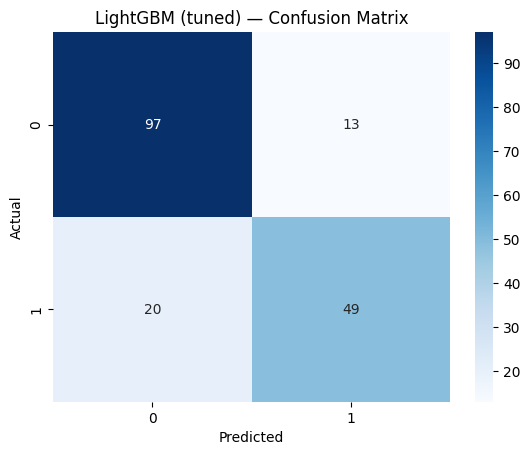


Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179


XGBoost (tuned) metrics:
Accuracy : 0.8100558659217877
Precision: 0.7777777777777778
Recall   : 0.7101449275362319
F1       : 0.7424242424242424
ROC-AUC  : 0.8538208168642951


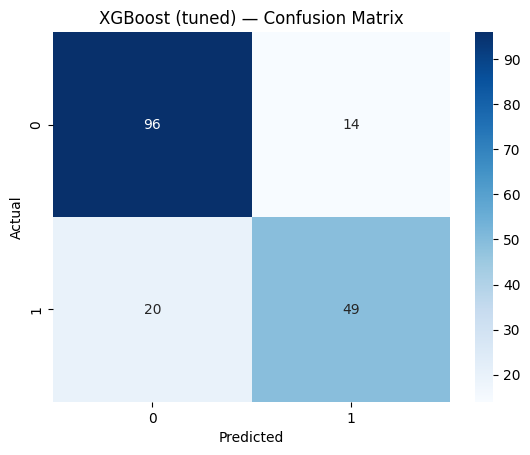


Classification report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [34]:
# Evaluate best estimators
best_lgbm = lgbm_search.best_estimator_
best_xgb  = xgb_search.best_estimator_

best_lgbm_pred = best_lgbm.predict(X_valid)
best_lgbm_proba = best_lgbm.predict_proba(X_valid)[:,1] if hasattr(best_lgbm.named_steps['clf'], "predict_proba") else None

best_xgb_pred = best_xgb.predict(X_valid)
best_xgb_proba = best_xgb.predict_proba(X_valid)[:,1] if hasattr(best_xgb.named_steps['clf'], "predict_proba") else None

print_metrics("LightGBM (tuned)", y_valid, best_lgbm_pred, best_lgbm_proba)
print_metrics("XGBoost (tuned)",  y_valid, best_xgb_pred,  best_xgb_proba)


In [35]:
# Comparison summary
def metrics_dict(y_true, y_pred, y_proba=None):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }

rows = [
    ('LGBM baseline',) + tuple(metrics_dict(y_valid, lgbm_pred, lgbm_proba).values()),
    ('XGB  baseline',) + tuple(metrics_dict(y_valid, xgb_pred, xgb_proba).values()),
    ('LGBM tuned',)    + tuple(metrics_dict(y_valid, best_lgbm_pred, best_lgbm_proba).values()),
    ('XGB  tuned',)    + tuple(metrics_dict(y_valid, best_xgb_pred, best_xgb_proba).values()),
]

comp = pd.DataFrame(rows, columns=['Model','Accuracy','Precision','Recall','F1','ROC-AUC'])
display(comp.sort_values('Accuracy', ascending=False))


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,LGBM baseline,0.821229,0.768116,0.768116,0.768116,0.838142
2,LGBM tuned,0.815642,0.790323,0.710145,0.748092,0.831159
3,XGB tuned,0.810056,0.777778,0.710145,0.742424,0.853821
1,XGB baseline,0.804469,0.750000,0.739130,0.744526,0.835639
